In [52]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm
import pandas as pd
import copy

Example with circulant dynamics

In [2]:
P_0_matrix=np.array([[0.5,0,0,0.5],
                   [0.5,0.5,0,0],
                   [0,0.5,0.5,0],
                   [0,0,0.5,0.5]])


In [3]:
P_1_matrix=P_0_matrix.transpose()

In [51]:
P_1_matrix

array([[0.5, 0.5, 0. , 0. ],
       [0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0.5, 0.5],
       [0.5, 0. , 0. , 0.5]])

In [4]:
action_space=[0,1]
state_space=[0,1,2,3]
reward_matrix=[-1,0,0,1]

In [5]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state]
  return [new_state,reward]

In [6]:
N=1000
M=500
epsilon=1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99

In [7]:
Q_values=[]
for i in range(N):
  Q_values.append([[-1,-1],[0,0],[0,0],[1,1]])

In [8]:
def Q_value_update(Q_values,state,next_state,action,reward,arm_index,subsidy,alpha):
  if action==1:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)
  else:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+subsidy+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)




In [9]:
alternative_indexes=[0 for _ in range(N)]

In [10]:
# def act(alternative_indexes,N,M,epsilon):
#   decision=np.random.binomial(n=1,p=epsilon,size=1)
#   if decision==1:
#     indices=random.choice([i for i in range(N)],k=M)
#   else:
#     indices = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
#   return indices

In [11]:
def act(Q_values,epsilon,state,arm_index):
  decision=np.random.binomial(n=1,p=epsilon,size=1)
  if decision==1:
    action=random.choice([0,1])
  else:
    action=np.argmax(Q_values[arm_index][state])
  return action



In [12]:
current_state=[0 for _ in range(N)]

In [13]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]

In [14]:
for i in range(1,100001):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  alpha=1/(1+(i/10000))
  beta=1/(1+(i*np.log(i)/10000))
  for index in arm_indexes:
      # action=np.argmax(Q_values[index][current_state[index]])
      action=act(Q_values,epsilon,current_state[index],index)
      action_sum+=action
      x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      Q_value_update(Q_values,current_state[index],new_state,action,reward,index,subsidy,alpha)
      current_state[index]=new_state
      reward_sum+=reward
  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)
  epsilon=epsilon*gamma
  if epsilon<=0.01:
    epsilon=0.01
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)








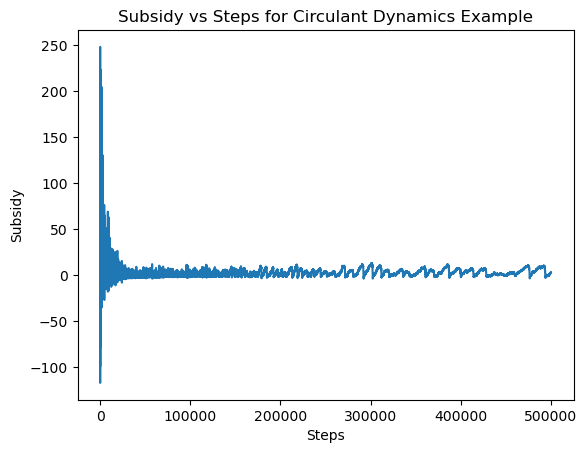

In [15]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Circulant Dynamics Example')


In [16]:
subsidies[-1]

3.2748509139524624

In [17]:
df=pd.DataFrame(rewards)


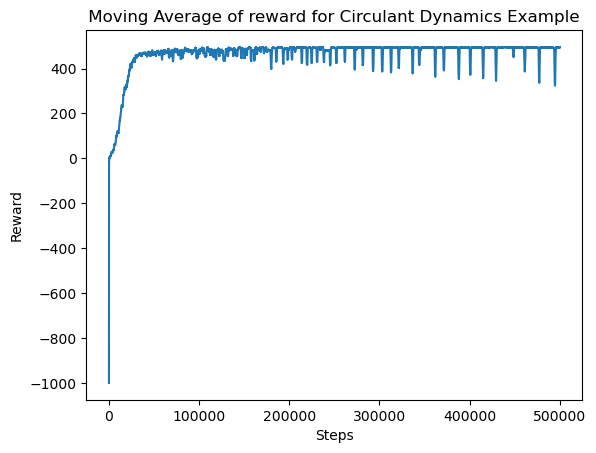

In [18]:
plt.plot(df[0].rolling(1000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Circulant Dynamics Example ')


In [19]:
for i in range(N):
  alternative_indexes[i]=Q_values[i][current_state[i]][1]-Q_values[i][current_state[i]][0]


(array([523.,   0.,   5., 472.]),
 array([-10.05514956,  -6.04702593,  -2.0389023 ,   1.96922133,
          5.97734496]),
 <BarContainer object of 4 artists>)

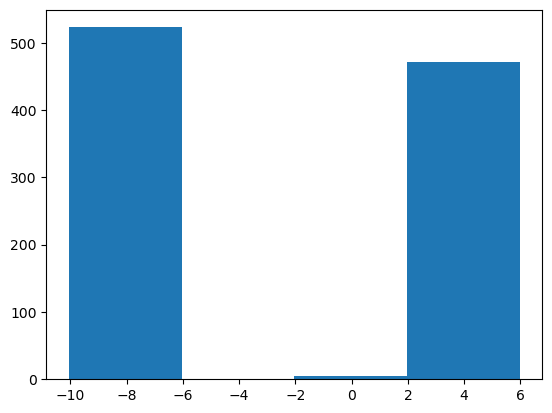

In [20]:
plt.hist(alternative_indexes,4)

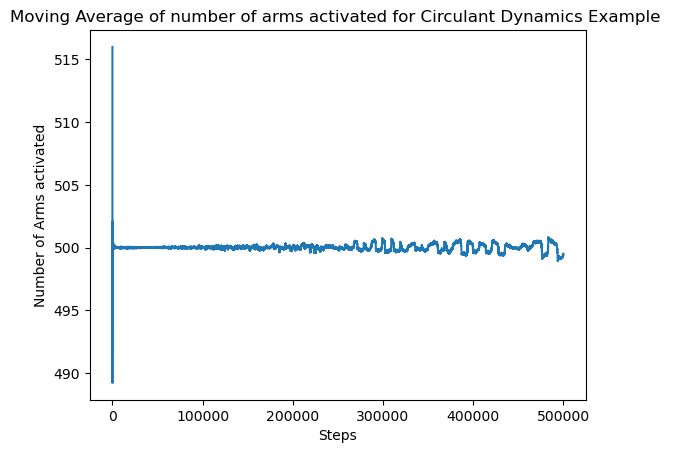

In [21]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(7000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title('Moving Average of number of arms activated for Circulant Dynamics Example ')


In [22]:
df

,0,action_sums
0,-1000,516
1,-242,495
2,-94,490
3,-70,477
4,-55,468
...,...,...
499995,495,497
499996,489,508
499997,504,493
499998,500,497


In [54]:
current_state_init=[]
for i in range(N):
    if i<N/6:
        current_state_init.append(0)
    elif i>=N/6 and i<N/2:
        current_state_init.append(1)
    else:
        current_state_init.append(2)

In [55]:
#using learnt indices
# current_state=[0 for _ in range(N)]
current_state=copy.deepcopy(current_state_init)
reward_sums_alt_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,50001):
  reward_sum_alt_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q_values[index][current_state[index]][1]-Q_values[index][current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)


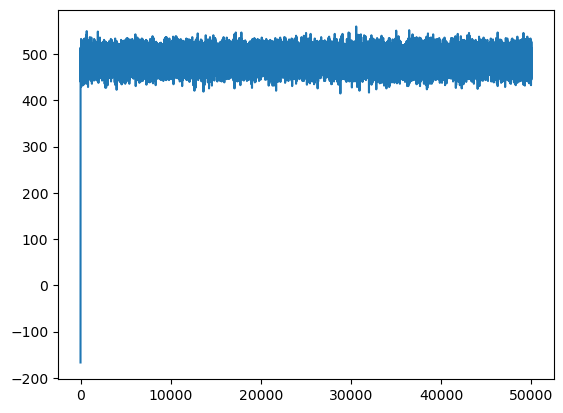

In [56]:
plt.plot(reward_sums_alt_index)

In [57]:
reward_sums_alt_index[-5]

445

In [58]:
whittle_index_arms=[0 for _ in range(N)]
current_state=copy.deepcopy(current_state_init)
reward_sums_whittle_index=[]
actual_whittle_indexes=[-0.5,0.5,1,-1]

for i in range(1,50001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    whittle_index_arms[index]=actual_whittle_indexes[current_state[index]]
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

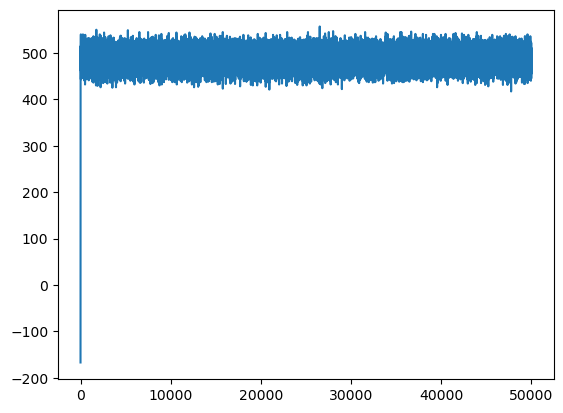

In [59]:
plt.plot(reward_sums_whittle_index)

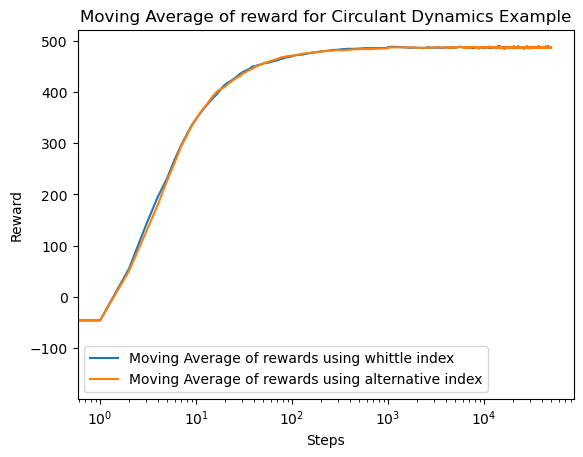

In [61]:
df_reward=pd.DataFrame()
df_reward['reward_whittle']=reward_sums_whittle_index
df_reward['reward_alternate']=reward_sums_alt_index
x=[i for i in range(50000)]
# plt.plot(df_reward['reward_whittle'].rolling(10,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
# plt.plot(df_reward['reward_alternate'].rolling(10,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.semilogx(x,df_reward['reward_whittle'].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.semilogx(x,df_reward['reward_alternate'].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title('Moving Average of reward for Circulant Dynamics Example')
plt.savefig('Moving Average of reward for Circulant Dynamics Example final.png')

In [31]:
x=df_reward['reward_alternate'][:50000].rolling(1000,min_periods=1).mean()
x

0       -1000.000000
1        -622.500000
2        -407.666667
3        -244.750000
4        -117.800000
            ...     
49995     486.077000
49996     486.101000
49997     486.116000
49998     486.147000
49999     486.149000
Name: reward_alternate, Length: 50000, dtype: float64

Example with restart

In [ ]:
P_0_matrix=np.array([[0.1,0.9,0,0,0],
                   [0.1,0,0.9,0,0],
                   [0.1,0,0,0.9,0],
                   [0.1,0,0,0,0.9],
                   [0.1,0,0,0,0.9]])
P_0_matrix


array([[0.1, 0.9, 0. , 0. , 0. ],
       [0.1, 0. , 0.9, 0. , 0. ],
       [0.1, 0. , 0. , 0.9, 0. ],
       [0.1, 0. , 0. , 0. , 0.9],
       [0.1, 0. , 0. , 0. , 0.9]])

In [ ]:
P_1_matrix=np.array([[1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0]])
P_1_matrix

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
action_space=[0,1]
state_space=[0,1,2,3,4]
A=0.9
reward_matrix=[[A**1,0],[A**2,0],[A**3,0],[A**4,0],[A**5,0]]
N=100
M=20
epsilon=1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99

In [ ]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [ ]:
Q_values=[]
for i in range(N):
  Q_values.append([[A**1,0],[A**2,0],[A**3,0],[A**4,0],[A**5,0]])

In [ ]:
def Q_value_update(Q_values,state,next_state,action,reward,arm_index,subsidy,alpha):
  if action==1:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)
  else:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+subsidy+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)




In [ ]:
def act(Q_values,epsilon,state,arm_index):
  decision=np.random.binomial(n=1,p=epsilon,size=1)
  if decision==1:
    action=random.choice([0,1])
  else:
    action=np.argmax(Q_values[arm_index][state])
  return action

In [ ]:
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]

In [ ]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=1

In [ ]:
for i in range(1,100000):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  alpha=1/(1+(i/2500))
  beta=1/(1+(i*np.log(i)/2500))
  for index in arm_indexes:
      # action=np.argmax(Q_values[index][current_state[index]])
      action=act(Q_values,epsilon,current_state[index],index)
      action_sum+=action
      x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      Q_value_update(Q_values,current_state[index],new_state,action,reward,index,subsidy,alpha)
      current_state[index]=new_state
      reward_sum+=reward
      #print(x)
  # print(i)
  #print(reward_sum)

  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)
  epsilon=epsilon*gamma
  if epsilon<=0.01:
    epsilon=0.01
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)








In [ ]:
reward_matrix

[[0.9, 0],
 [0.81, 0],
 [0.7290000000000001, 0],
 [0.6561, 0],
 [0.5904900000000001, 0]]

Text(0.5, 1.0, 'Subsidy vs Steps for Circulant Restart Example')

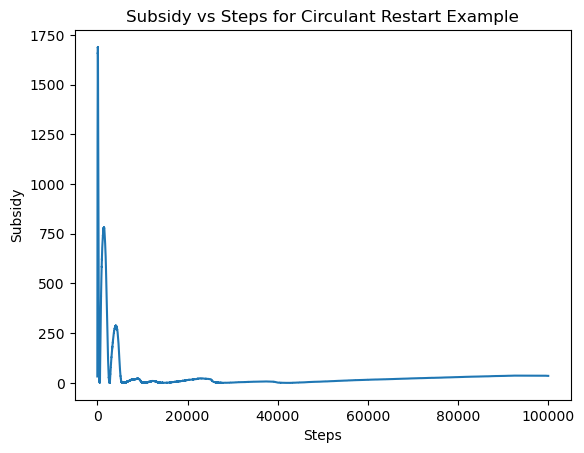

In [ ]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Circulant Restart Example')

In [ ]:
subsidies[-5]

35.051085537918354

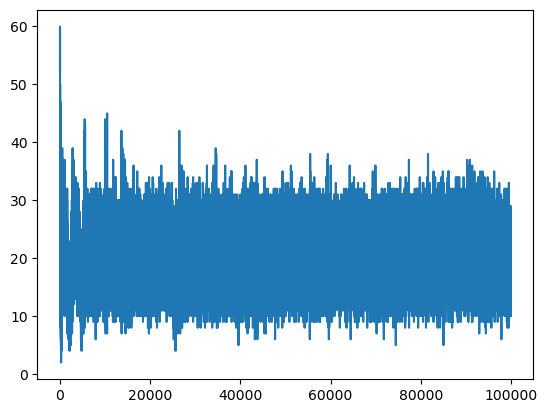

In [ ]:
plt.plot(action_sums)

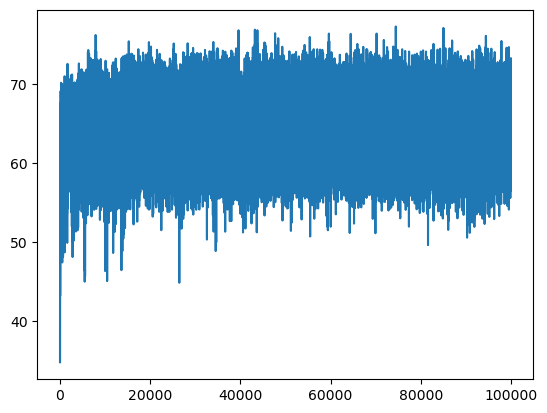

In [ ]:
plt.plot(rewards)